In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as snb
import plotly.express as ex
from datetime import datetime
import os
import sys 
import joblib
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")


In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [3]:
import tensorflow as tf
from keras.layers import (
    Input,
    LSTM,
    Dropout,
    Dense
)
from keras.models import (
    Model,
    Sequential,
    load_model
)
from keras.metrics import MeanAbsoluteError

In [4]:

scaler_file_path="E:/data_science_play_ground/gold_price_prediction/ztester/price_MinMaxScaler_07_09_25__06h_01m_03s.pkl"

scaler=joblib.load(scaler_file_path)

In [5]:
def locate_input_file(input_file_name):
    try:
        dir_name=os.getcwd()
        input_file_path=os.path.join(dir_name,input_file_name)
        # print(input_file_path)
        return input_file_path
    
    except Exception as e:
        print(f"error : {e}")

In [6]:
def get_input_data(file_path):
    
    try:
        df=pd.read_csv(file_path)
        return df
    
    except Exception as e:
        print(f"error : {e}")



In [7]:
def print_details(df):
    try:
        print(f"shape of df : {df.shape}\n")
        print(f"columns of df : {df.columns}\n\n")
        print(f"information about df : \n{df.info()}\n\n")
        print(f"description about df : \n{df.describe()}\n\n")
        print(f"head of df : \n{df.head()}\n\n")
        print(f"tail of df : \n{df.tail()}\n\n")

        for col in df.columns:    
            print(f"value count of df : \n {df[col].value_counts()}")    

    except Exception as e:
        print(f"error : {e}")

In [8]:
def remove_unwanted_columns(df,unwanted_columns):
    try:
        # unwanted_columns=['Open', 'High', 'Low', 'Vol.', 'Change %']
        unwanted_count=len(unwanted_columns)
        # print(unwanted_count)
        temp_count=0
        for col in unwanted_columns:
            if col in df.columns:
                temp_count+=1

        
        if temp_count==unwanted_count :
            print(f"all unwanted columns can be removed.")
        else:
            print(f"all unwanted columns can not be removed.")

        df=df.drop(columns=unwanted_columns,axis=1)

        return df
    
    except Exception as e:
        print(f"error : {e}")

In [9]:
def sort_date(df):
    try:
        df.sort_values(
            by=["Date"],
            axis=0,
            ascending=True,
            inplace=True
        )
        return df

    except Exception as e:
        print(f"error : {e}")

In [28]:
def clean_data(df):
    try:
        df["Date"]=pd.to_datetime(df["Date"])
        df["Price"]=df["Price"].str.replace(",","").astype(float)
        df["Price"]=scaler.transform(df[["Price"]])
        df=sort_date(df)

        return df

    except Exception as e:
        print(f"error : {e}")

In [11]:
def handle_missing(df):
    try:
        print(f"Column-wise missing values:\n{df.isnull().sum()}\n")
        print(f"Total missing values: {df.isnull().sum().sum()}\n")

        num_cols = df.select_dtypes(include=["int64", "float64"]).columns
        cat_cols = df.select_dtypes(include="object").columns

        print(f"Numerical columns: {list(num_cols)}")
        print(f"Categorical columns: {list(cat_cols)}")

        # Fill missing values
        for col in num_cols:
            df[col] = df[col].fillna(df[col].mean())

        for col in cat_cols:
            df[col] = df[col].fillna(df[col].mode()[0])

        return df

    except Exception as e:
        print("Error:", e)
def handle_missing(df):
    try:
        print(f"Column-wise missing values:\n{df.isnull().sum()}\n")
        print(f"Total missing values: {df.isnull().sum().sum()}\n")

        num_cols = df.select_dtypes(include=["int64", "float64"]).columns
        cat_cols = df.select_dtypes(include="object").columns

        print(f"Numerical columns: {list(num_cols)}")
        print(f"Categorical columns: {list(cat_cols)}")

        # Fill missing values
        for col in num_cols:
            df[col] = df[col].fillna(df[col].mean())

        for col in cat_cols:
            df[col] = df[col].fillna(df[col].mode()[0])

        return df

    except Exception as e:
        print("Error:", e)


In [12]:
def handle_duplicate(df):
    try:
        duplicate_count=df.duplicated().sum()
        print(f"duplicated  values : {duplicate_count}")
        
        if duplicate_count>0:
            df.drop_duplicates(ignore_index=True)

        return df

    except Exception as e:
        print(e)

In [13]:
def build_train_dataset(df,start_point,test_size,window):
    try:
        train_data=df["Price"][:-test_size].to_numpy().reshape(-1,1)
        date_train=[]
        x_train=[]
        y_train=[]

        for i in range(start_point+1,len(train_data)):
            x_train.append(train_data[i-window:i,0])
            y_train.append(train_data[i,0])
            date_train.append(df["Date"].iloc[i])
            # date_train.append(df["Date"][i])

        x_train=np.array(x_train)
        y_train=np.array(y_train)
        date_train=np.array(date_train)

        print(f"date_train shape :{date_train.shape}")
        print(f"x_train shape :{x_train.shape}")
        print(f"y_train shape :{y_train.shape}")


        return date_train,x_train,y_train

    except Exception as e:
        print(f"error : {e}")

In [103]:
def build_test_data(df, test_size, window):
    x_test = []
    y_test = []
    date_test = []

    last_index = len(df)

    for i in range(last_index - test_size, last_index):
        if i - window >= 0:
            seq = df["Price"].iloc[i - window:i].values.reshape(-1, 1)  # shape (window, 1)
            x_test.append(seq)      # add sequence
            y_test.append(df["Price"].iloc[i]) 
            date_test.append(df["Date"].iloc[i])

    x_test = np.array(x_test)       # shape (samples, window, 1)
    y_test = np.array(y_test)
    date_test = np.array(date_test)

    print(f"x_test shape: {x_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"date_test length: {len(date_test)}")

    
    return date_test,x_test, y_test


In [14]:
# def build_test_dataset(df,start_point,test_size,window):
#     try:
                
#         test_data=df["Price"][-test_size-window:].to_numpy().reshape(-1,1)
#         x_test=[]
#         y_test=[]

#         for i in range(window,len(test_data)):
#             x_test.append(test_data[i-window:i,0])
#             y_test.append(test_data[i,0])

#         x_test=np.array(x_test)
#         y_test=np.array(y_test)
        
#         print(f"date_train shape :{date_train.shape}")
#         print(f"x_train shape :{x_train.shape}")
#         print(f"y_train shape :{y_train.shape}")

#         return x_test,y_test

#     except Exception as e:
#         print(f"error : {e}")

In [31]:
def test_training():
    try:
        input_file_path="E:/data_science_play_ground/gold_price_prediction/gold_price_2013_2023.csv"
        print(input_file_path)  


        df=get_input_data(input_file_path)
        print_details(df)

        unwanted_columns=['Open', 'High', 'Low', 'Vol.', 'Change %']
        df=remove_unwanted_columns(df,unwanted_columns)
        print_details(df)

        df=clean_data(df)
        print(df.head())
        print(df.tail())
        

        df=handle_missing(df)

        df=handle_duplicate(df)

        return df



    except Exception as e:
        print(f"error : {e}")

In [30]:
df=test_training()
print(f"type of df : {type(df)}")

E:/data_science_play_ground/gold_price_prediction/gold_price_2013_2023.csv
shape of df : (2583, 7)

columns of df : Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2583 non-null   object
 1   Price     2583 non-null   object
 2   Open      2583 non-null   object
 3   High      2583 non-null   object
 4   Low       2583 non-null   object
 5   Vol.      2578 non-null   object
 6   Change %  2583 non-null   object
dtypes: object(7)
memory usage: 141.4+ KB
information about df : 
None


description about df : 
              Date     Price      Open      High       Low   Vol. Change %
count         2583      2583      2583      2583      2583   2578     2583
unique        2583      2072      2061      2044      2019   1550      474
top     12/30/2022  1,294.30

In [42]:
print(f"columns : {df.columns}")

columns : Index(['Date', 'Price'], dtype='object')


In [32]:
df.head(),df.tail()

(           Date     Price
 2582 2013-01-02  0.634715
 2581 2013-01-03  0.620539
 2580 2013-01-04  0.595063
 2579 2013-01-07  0.592387
 2578 2013-01-08  0.608247,
         Date     Price
 4 2022-12-26  0.753469
 3 2022-12-27  0.766753
 2 2022-12-28  0.759516
 1 2022-12-29  0.769627
 0 2022-12-30  0.769826)

In [33]:
windows=[60,120,240]
mx_size=max(windows)
test_size=df[df["Date"].dt.year==2022].shape[0]

windows,mx_size,test_size

([60, 120, 240], 240, 260)

In [34]:
def plot_difference_figure(
        x1,y1,
        x2,y2
):
    try:
        plt.figure(
            figsize=(15,6),
            dpi=150
        )
        plt.rcParams["axes.facecolor"] = "pink"
        plt.rcParams["axes.edgecolor"] = "white"
        plt.plot(
            x1,y1,
            color="blue",
            lw=2
        )
        plt.plot(
            x2,y2,
            color="yellow",
            lw=2
        )
        plt.legend(
            [
                "Training set",
                "Test set"
            ],
            loc="upper left",
            prop={"size":15}
        )
        plt.grid(color="white")
        plt.show()


    except Exception as e:
        print(f"error : {e}")

In [35]:
def plot_figure(x,y):
    plt.plot(
        x,y,
        color="yellow",
        lw=2
    )
    plt.show()

date_train shape :(2081,)
x_train shape :(2081, 60)
y_train shape :(2081,)
start date : 2013-12-09 00:00:00,end date : 2021-12-31 00:00:00
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


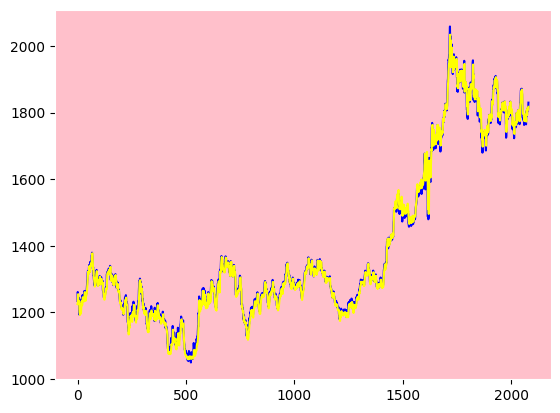

date_train shape :(2081,)
x_train shape :(2081, 120)
y_train shape :(2081,)
start date : 2013-12-09 00:00:00,end date : 2021-12-31 00:00:00
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step


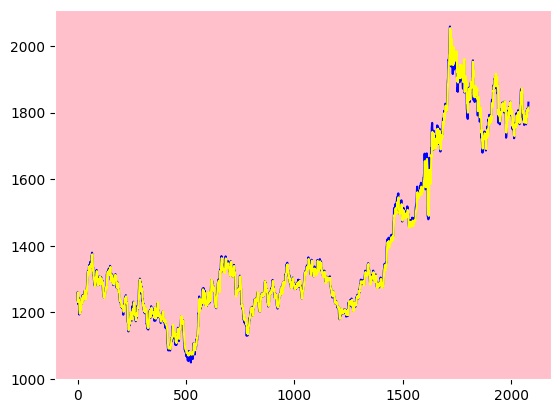

date_train shape :(2081,)
x_train shape :(2081, 240)
y_train shape :(2081,)
start date : 2013-12-09 00:00:00,end date : 2021-12-31 00:00:00
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 176ms/step


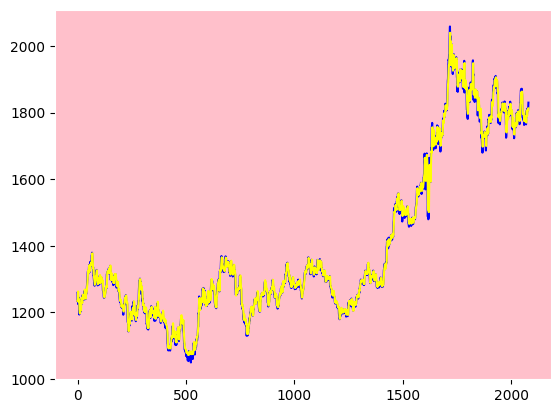

In [43]:
for window in windows:
    model_file_name=f"model_{window}_.keras"
    model = load_model(model_file_name)  

    date,x_train,y_train=build_train_dataset(
        df,
        mx_size+1,
        test_size,
        window
    )
    print(f"start date : {date[0]},end date : {date[-1]}")

    y_pred=model.predict(x_train)

    y_train_inverse_scaled=scaler.inverse_transform(y_train.reshape(-1,1))
    y_pred_inverse_scaled=scaler.inverse_transform(y_pred.reshape(-1,1))

    # plot_difference_figure(
    #     df["Date"],df["Price"],
    #     date,y_pred_inverse_scaled
    # )

    # for val1,val2 in  list(zip(y_train_inverse_scaled,y_pred_inverse_scaled))[:5]:
    #     print(f"{val1} , {val2}")

    # print("\n")    
    

    # plot_figure(date,y_pred)
    # plot_figure(date,y_train)

    plt.plot(y_train_inverse_scaled,color="blue")
    plt.plot(y_pred_inverse_scaled,color="yellow")
    plt.show()

In [ ]:
test_size=df[df["Date"].dt.year==2022].shape[0]
window=120

x_test,y_test,date_test=build_test_data(df,test_size,window)

In [85]:
len(x_test[0])

120

x_test shape: (260, 60, 1)
y_test shape: (260,)
date_test length: 260
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


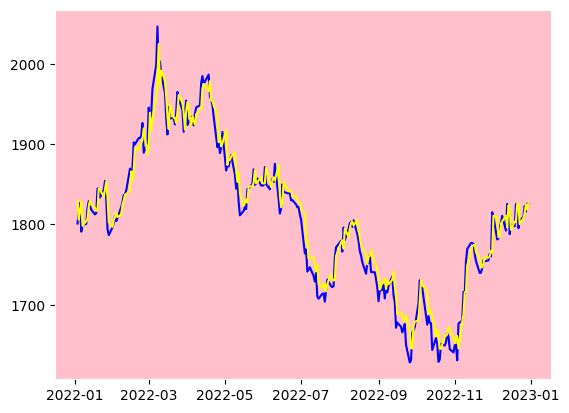

x_test shape: (260, 120, 1)
y_test shape: (260,)
date_test length: 260
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


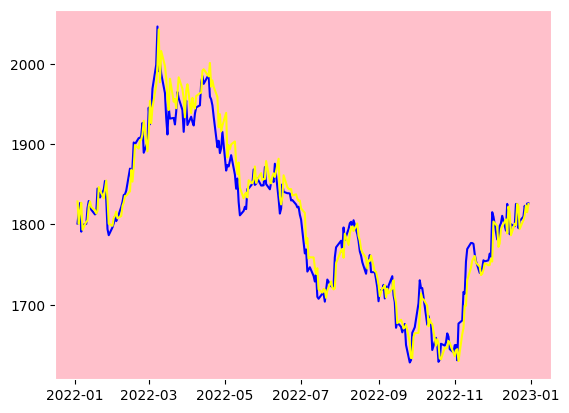

x_test shape: (260, 240, 1)
y_test shape: (260,)
date_test length: 260
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step


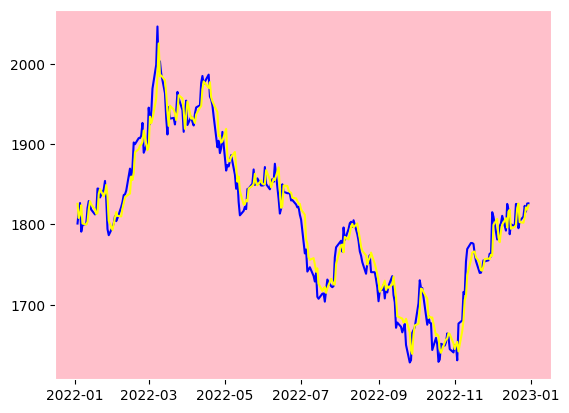

In [106]:
windows=[60,120,240]

for window in windows:
    model_file_name=f"model_{window}_.keras"
    model = load_model(model_file_name)  

    date_test,x_test,y_test=build_test_data(df,test_size,window)

    # print(f"start date : {date_test[0]},end date : {date_test[-1]}")
    # print(f"data in x_test  : {len(x_test)}")
    # print(f"data in y_test  : {len(y_test)}")
    # print(f"columns in x_test : {len(x_test[0])}\n")
        
    y_pred=model.predict(x_test)

    y_test_inverse_scaled=scaler.inverse_transform(y_test.reshape(-1,1))
    y_pred_inverse_scaled=scaler.inverse_transform(y_pred)

    # plot_difference_figure(
    #     df["Date"],df["Price"],
    #     date,y_pred_inverse_scaled
    # )

    # for val1,val2 in  list(zip(y_train_inverse_scaled,y_pred_inverse_scaled))[:5]:
    #     print(f"{val1} , {val2}")

    # print("\n")    
    

    # plot_figure(date,y_pred)
    # plot_figure(date,y_train)

    plt.plot(date_test,y_test_inverse_scaled,color="blue")
    plt.plot(date_test,y_pred_inverse_scaled,color="yellow")
    plt.show()